<a href="https://colab.research.google.com/github/CPO-atu/Big-Data-Project/blob/main/FinancialFraudDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Fraud Detection Application

**STEP 1: DATA CLEANING**




In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sriharshaeedala/financial-fraud-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [00:05<00:00, 36.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sriharshaeedala/financial-fraud-detection-dataset/versions/1


In [2]:
import os
import pandas as pd

# Check what's inside the downloaded directory
dataset_dir = "/root/.cache/kagglehub/datasets/sriharshaeedala/financial-fraud-detection-dataset/versions/1"
print("Files in dataset directory:", os.listdir(dataset_dir))

# Find the actual data file (CSV, Excel, etc.)

path = os.path.join(dataset_dir, "Synthetic_Financial_datasets_log.csv")  # Adjust filename

# Load into DataFrame
df = pd.read_csv(path)  # Use pd.read_excel() for Excel files

df.head()

Files in dataset directory: ['Synthetic_Financial_datasets_log.csv']


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


For the purpose of this project, I would make use of only 500,000 rows of the data. However, I will include all the rows that are tagged as fraud in the 500,000 rows I will be using.

In [3]:
# Separate fraud and non-fraud
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]

# Get number of fraud rows
num_fraud = len(fraud_df)


num_to_sample = 500000 - num_fraud
non_fraud_sample = non_fraud_df.sample(n=num_to_sample, random_state=42)

# Combine both
fd_df = pd.concat([fraud_df, non_fraud_sample], ignore_index=True)

# Optional: shuffle the final dataset
fd_df = fd_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
#Look through the contents of the dataset. Check for missing and null values

fd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB


In [5]:
# Total missing values per column
print(fd_df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
#Next, we check the statistics of the data, ensuring we look at numerical and non-numerical dataset

# Numerical columns
print(fd_df.describe())  # Mean, min, max, etc.

# Categorical columns
print(fd_df.describe(include='object'))  # Counts, unique values

                step        amount  oldbalanceOrg  newbalanceOrig  \
count  500000.000000  5.000000e+05   5.000000e+05    5.000000e+05   
mean      245.482400  1.998823e+05   8.492884e+05    8.482228e+05   
std       144.530584  6.818953e+05   2.906360e+06    2.918419e+06   
min         1.000000  0.000000e+00   0.000000e+00    0.000000e+00   
25%       156.000000  1.376301e+04   0.000000e+00    0.000000e+00   
50%       249.000000  7.741422e+04   1.508495e+04    0.000000e+00   
75%       346.000000  2.134742e+05   1.168425e+05    1.391233e+05   
max       743.000000  6.988673e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    5.000000e+05    5.000000e+05  500000.000000   500000.000000  
mean     1.100610e+06    1.234317e+06       0.016426        0.000032  
std      3.475024e+06    3.740286e+06       0.127107        0.005657  
min      0.000000e+00    0.000000e+00       0.000000        0.000000  
25%      0.000000e+00  

In [7]:
fd_df.shape

(500000, 11)

**STEP 2: DATA PREPROCESSING**


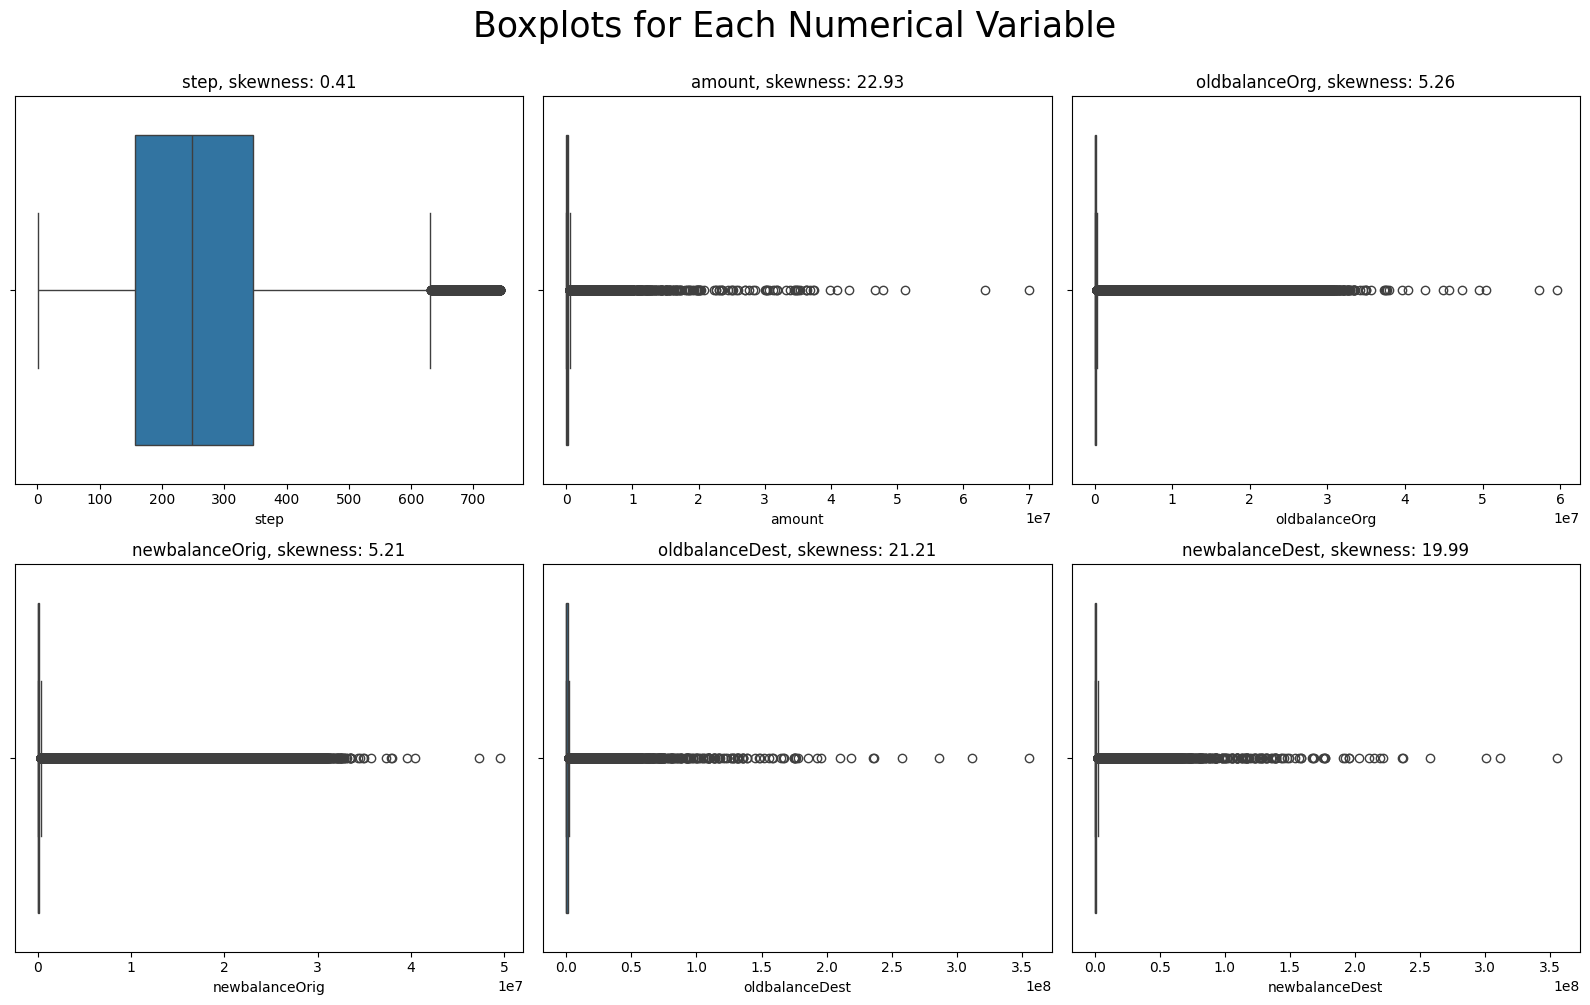

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = ['step','amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Create a custom function for plotting boxplots for each numerical column
def boxplots_custom(dataset, columns_list, suptitle):
    num_columns = len(columns_list)
    cols = 3
    rows = (num_columns // cols) + (num_columns % cols > 0)
    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(16, rows * 5))
    fig.suptitle(suptitle, y=1, size=25)
    axs = axs.flatten()

    #Plot boxplots for each column
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        skewness = dataset[data].skew()
        axs[i].set_title(f"{data}, skewness: {round(skewness, 2)}")

    for i in range(num_columns, len(axs)):
        fig.delaxes(axs[i])


    plt.tight_layout()


boxplots_custom(dataset=fd_df, columns_list=numeric_columns, suptitle='Boxplots for Each Numerical Variable')


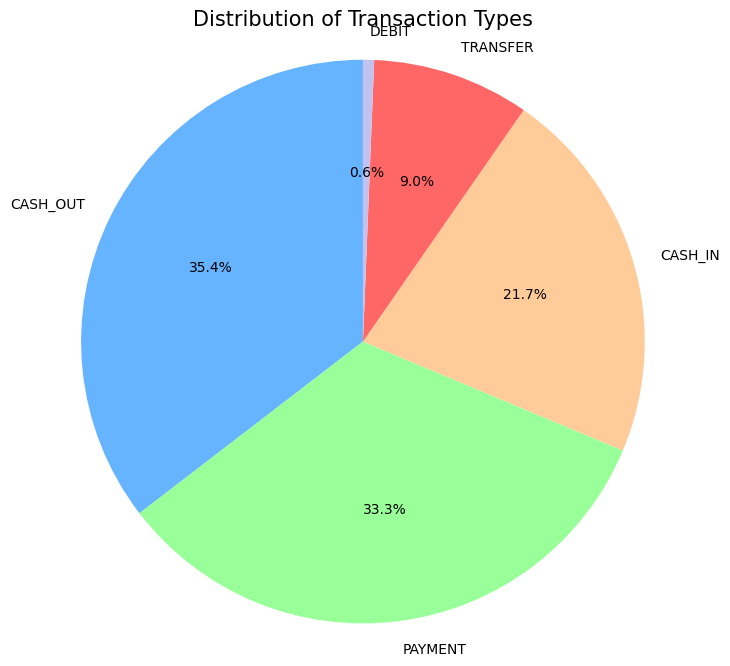

In [9]:
import matplotlib.pyplot as plt

# Count the occurrences of each type in the 'type' column
type_counts = fd_df['type'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0'])
plt.title('Distribution of Transaction Types', size=15)
plt.axis('equal')
plt.show()


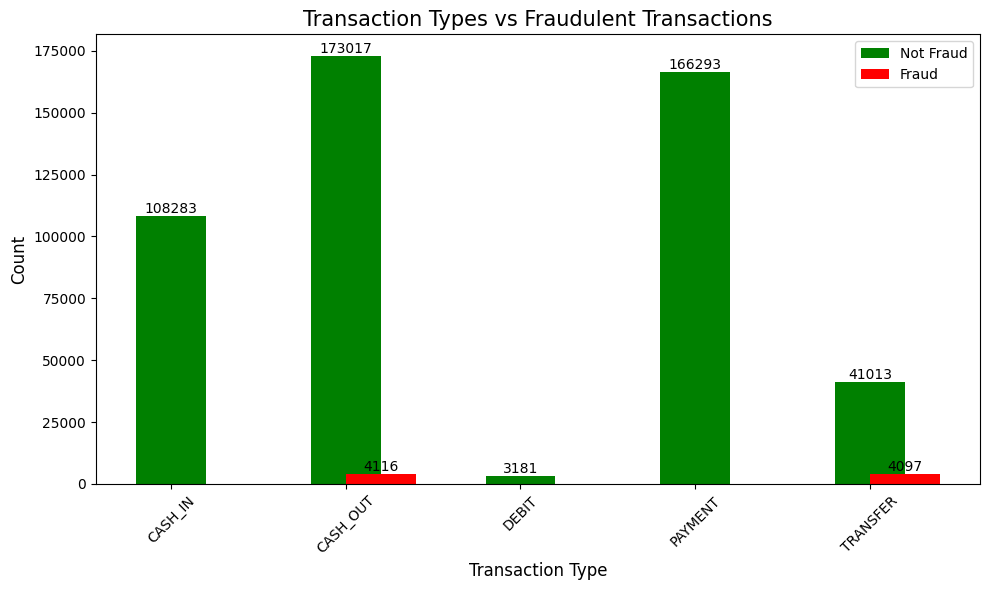

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by 'type' and 'isFraud' and get the count
type_fraud_counts = fd_df.groupby(['type', 'isFraud']).size().reset_index(name='count')

# Set the figure size
plt.figure(figsize=(10, 6))


type_fraud_counts['color'] = type_fraud_counts['isFraud'].map({0: 'green', 1: 'red'})

# Plot the bar chart
bars = plt.bar(type_fraud_counts[type_fraud_counts['isFraud'] == 0]['type'],
               type_fraud_counts[type_fraud_counts['isFraud'] == 0]['count'],
               color='green', label='Not Fraud', width=0.4, align='center')

bars2 = plt.bar(type_fraud_counts[type_fraud_counts['isFraud'] == 1]['type'],
                type_fraud_counts[type_fraud_counts['isFraud'] == 1]['count'],
                color='red', label='Fraud', width=0.4, align='edge')

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, str(int(height)), ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, str(int(height)), ha='center', va='bottom', fontsize=10)

# Set chart title and labels
plt.title('Transaction Types vs Fraudulent Transactions', size=15)
plt.xlabel('Transaction Type', size=12)
plt.ylabel('Count', size=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the visualisations above, we take naote of the following key observations;

We have outliers, however due to the nature of our analysis, we will not be removing the outliers because they could be potential fraud.

Fraud only occurs in TRANSFER and CASH_OUT transactions.

TRANSFER has the highest fraud rate (~2.3%) relative to its total count.

Even though PAYMENT is very common, no frauds are reported in this category making it the safest type.

DEBIT and CASH_IN are also fraud-free in this dataset.

The overall fraud rate is low (~1.6%), but targeted suggesting that fraudsters are selective and prefer channels where funds can be quickly moved or withdrawn.

**STEP 3: FEATURE SELECTION & FEATURE ENGINEERING**

Here, we will make use of Statistical analysis ANOVA and Chi-Square tests to select features:

The ANOVA test evaluates whether there are statistically significant differences in the means of a continuous feature across different categories of a categorical target variable. It helps identify features that best distinguish between classes.

The Chi-Square test measures the dependence or association between two categorical variables. In feature selection, it evaluates whether there is a significant relationship between each feature (categorical) and the target variable (also categorical).

In [11]:
from scipy.stats import chi2_contingency, f_oneway

def chi_square_test(fd_df, categorical_features, target_variable):
    chi2_results = {}
    for feature in categorical_features:
        # Create a contingency table between the feature and target variable
        contingency_table = pd.crosstab(fd_df[feature], fd_df[target_variable])

        # Perform Chi-square test
        chi2, p, _, _ = chi2_contingency(contingency_table)

        # Store the results (chi2 statistic and p-value)
        chi2_results[feature] = {'chi2': chi2, 'p_value': p}

    return chi2_results


def f_test(fd_df, continuous_features, target_variable):
    f_test_results = {}
    for feature in continuous_features:
        # Group data by target variable and perform One-way ANOVA (F-test)
        group_0 = fd_df[fd_df[target_variable] == 0][feature]  # Group for non-fraud (isFraud == 0)
        group_1 = fd_df[fd_df[target_variable] == 1][feature]  # Group for fraud (isFraud == 1)

        # Perform One-way ANOVA (F-test)
        f_stat, p_value = f_oneway(group_0, group_1)

        # Store the results (F-statistic and p-value)
        f_test_results[feature] = {'F_stat': f_stat, 'p_value': p_value}

    return f_test_results


categorical_features = ['type', 'nameOrig', 'nameDest', 'isFlaggedFraud']
continuous_features = ['step','amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Chi-square test for categorical features
chi2_results = chi_square_test(fd_df, categorical_features=categorical_features, target_variable='isFraud')

# One-way ANOVA (F-test) for continuous features
f_test_results = f_test(fd_df, continuous_features=continuous_features, target_variable='isFraud')

# Print results
print("Chi-Square Test Results:")
print(chi2_results)

print("\nOne-way ANOVA (F-test) Results:")
print(f_test_results)

Chi-Square Test Results:
{'type': {'chi2': np.float64(20601.10827936858), 'p_value': np.float64(0.0)}, 'nameOrig': {'chi2': np.float64(499969.0521027808), 'p_value': np.float64(0.4897404200139675)}, 'nameDest': {'chi2': np.float64(407192.5124695916), 'p_value': np.float64(8.283702429120022e-233)}, 'isFlaggedFraud': {'chi2': np.float64(898.1822754071076), 'p_value': np.float64(2.437657342094466e-197)}}

One-way ANOVA (F-test) Results:
{'step': {'F_stat': np.float64(6114.760740725651), 'p_value': np.float64(0.0)}, 'amount': {'F_stat': np.float64(30647.225584608903), 'p_value': np.float64(0.0)}, 'oldbalanceOrg': {'F_stat': np.float64(634.0700615432177), 'p_value': np.float64(7.963963777668632e-140)}, 'newbalanceOrig': {'F_stat': np.float64(422.03439085126354), 'p_value': np.float64(9.626706038359167e-94)}, 'oldbalanceDest': {'F_stat': np.float64(214.1292774424113), 'p_value': np.float64(1.7662885488786805e-48)}, 'newbalanceDest': {'F_stat': np.float64(1.2297411596366972), 'p_value': np.fl

Note: A good p-value is from 0.05 to 0 i.e the closer to 0, the better. Then, the interpretation of the F-statistic and the Chi-square values should be done in conjunction with the p-values, the higher their values, the better.

Based on the statistical analysis above, we will make use of the step, isFlaggedFraud, type, amount, newbalanceOrig, oldbalanceDest, and oldbalanceOrg columns for our analysis.

In [12]:
# One-hot encode the 'type' column
fd_onehot= pd.get_dummies(fd_df, columns=["type"])
fd_onehot.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,21,190113.45,C2045692692,0.0,0.00,C1569819494,251102.85,441216.30,0,0,False,True,False,False,False
1,44,38137.71,C1435885363,93155.0,131292.71,C499505383,0.00,0.00,0,0,True,False,False,False,False
2,284,16742.91,C171790979,0.0,0.00,C1713137232,87707.39,104450.30,0,0,False,True,False,False,False
3,188,158682.18,C1442293701,199211.0,40528.82,C641213606,0.00,158682.18,0,0,False,True,False,False,False
4,426,5604.37,C12314025,0.0,0.00,M501760897,0.00,0.00,0,0,False,False,False,True,False



Since we are dealing with a highly imbalanced dataset where the minority class accounts for approximately 2.3% of the data, it is crucial to stratify the data before splitting it into training and test sets. Stratification ensures that the percentage of the minority class in the training set is proportionally replicated in the test set, preserving the class distribution and enabling more reliable model evaluation. Additionally, to address the challenges posed by the imbalance, we will perform SMOTE (Synthetic Minority Over-sampling Technique) analysis on the training data. This approach generates synthetic samples for the minority class, balancing the dataset and enhancing the model's ability to learn patterns from the underrepresented class while maintaining the integrity of the test set for unbiased performance assessment.

In [ ]:
pip install imbalanced-learn

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Drop Unnecessary Columns
fd_onehot = fd_onehot.drop(columns=['nameOrig', 'nameDest','newbalanceDest'])

# Split Features and Target
X = fd_onehot.drop(columns=['isFraud'])
y = fd_onehot['isFraud']

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Apply SMOTE for Imbalanced Data
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [87]:
feature_names = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'isFlaggedFraud', 'type_CASH_IN',
    'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'
]

X_test_df = pd.DataFrame(X_test, columns=feature_names)

**STEP 4: TRAIN THE MODEL**

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, roc_curve, auc, classification_report
from sklearn.metrics import log_loss

rf_model= RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

#Evaluate Model
y_pred_rf = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

#Compute ROC curve
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_proba)

# Compute AUC
roc_auc_rf = auc(rf_fpr, rf_tpr)

In [15]:
from xgboost import XGBClassifier

# Compute the scale_pos_weight (ratio of negative to positive samples in the training set)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize the XGBoost model
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train the model on the SMOTE-resampled data
xgb_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred_xgb = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

#Compute ROC curve
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb_proba)

# Compute AUC
roc_auc_xgb = auc(xgb_fpr, xgb_tpr)
print('\n')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:39:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
print("RandomForestClassifier Results:")
print("Model Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_rf}")


print("\nXGBoost Results:")
print("Model Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n Classification Report:\n",classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_xgb}")


RandomForestClassifier Results:
Model Accuracy: 0.99781

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     98357
           1       0.89      0.99      0.94      1643

    accuracy                           1.00    100000
   macro avg       0.94      1.00      0.97    100000
weighted avg       1.00      1.00      1.00    100000

ROC-AUC Score: 0.9992793248582427

XGBoost Results:
Model Accuracy: 0.99334

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     98357
           1       0.71      1.00      0.83      1643

    accuracy                           0.99    100000
   macro avg       0.86      1.00      0.91    100000
weighted avg       1.00      0.99      0.99    100000

ROC-AUC Score: 0.9996354529756523


Comparing the results above. We observe that both the RandomForestClassifier and XGBoost models demonstrate exceptional performance with high accuracy (>99%) and ROC-AUC scores (>0.999), indicating strong discriminative power for fraud detection. However, the RandomForestClassifier outperforms XGBoost in terms of balanced metrics for the minority class (fraud), achieving a precision of 0.89 and a recall of 0.99, compared to XGBoost's precision of 0.71 despite its marginally higher ROC-AUC. The lower precision of XGBoost results in a higher rate of false positives, which can be operationally inefficient in real-world applications. Consequently, the RandomForestClassifier is the more suitable choice as it effectively minimizes false alarms while maintaining robust fraud detection capabilities, aligning with the practical demands of operational efficiency and reliability in fraud detection systems.

In [17]:
import joblib

# Save the trained model using joblib
model_filename = 'rf_model.pkl'
joblib.dump(rf_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to rf_model.pkl
